In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Adiciona o caminho da raiz do projeto (BINARYCLASSIFICATION) ao sys.path
sys.path.append(os.path.abspath(".."))


In [2]:
df = pd.read_csv("../data/class_imbalance/dataset_38_sick.csv")

In [3]:
print(df.head())

    age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41.0   F            f                  f                         f    f   
1  23.0   F            f                  f                         f    f   
2  46.0   M            f                  f                         f    f   
3  70.0   F            t                  f                         f    f   
4  70.0   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

     TT4 T4U_measured   T4U FTI_measured    

In [4]:
print(df.value_counts(df.columns[-1]))

Class
negative    3541
sick         231
Name: count, dtype: int64


In [5]:
df["Class"] = df["Class"].map({"negative": 0, "sick": 1})


In [6]:
binary_map = {"t": 1, "f": 0, "M": 1, "F": 0}
df = df.replace(binary_map)


/tmp/ipykernel_20610/812959018.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


In [7]:
df = df.replace("?", np.nan)

In [8]:
df = df.drop(columns=["referral_source"])


In [9]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns

# Preenche colunas numéricas com a média
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

# Preenche colunas categóricas com a moda (linha por linha, seguro)
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()
        if not moda.empty:
            df[col] = df[col].fillna(moda.iloc[0])


In [10]:
print("Valores ausentes restantes:", df.isnull().sum().sum())


Valores ausentes restantes: 3772


In [11]:
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))


TBG    3772
dtype: int64


In [12]:
df = df.drop(columns=["TBG"])


In [13]:
X = df.drop("Class", axis=1).values
y = df["Class"].values


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # mantém proporção das classes
)




In [15]:
from src.BCE_Logistic_regression import LogisticRegression

# Treinamento com BCE
model_bce = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000)
model_bce.fit(X_train, y_train)

# Previsões de probabilidade no conjunto de teste
probs = model_bce.predict_proba(X_test)

# Inspeção das saídas
print("Probabilidades previstas (amostra):", probs[:10])
print("Min/Max das probabilidades:", np.min(probs), np.max(probs))

# Salvando erros para comparar modelos 
errors_bce = model_bce.errors

Probabilidades previstas (amostra): [0.1161228  0.03507247 0.02138131 0.04292207 0.15089278 0.00244485
 0.08737613 0.00155515 0.07339686 0.04427602]
Min/Max das probabilidades: 8.829049286340589e-07 0.5496413622204256


In [16]:
"""
### Situação e Interpretação de probabilidade no conjunto de teste

- **Todas as probs perto de 0**  
    O modelo só prevê a classe 0 (underfitting ou classe dominante).

- **Todas as probs perto de 1**  
    O modelo só prevê a classe 1 (mesmo problema invertido).

- **Todas as probs em torno de 0.5**  
    O modelo não aprendeu nada útil (provável má inicialização ou erro de loss).

- **Probs bem distribuídas (entre 0.1 e 0.9)**  
    Bom sinal de que está aprendendo
"""

'\n### Situação e Interpretação de probabilidade no conjunto de teste\n\n- **Todas as probs perto de 0**  \n    O modelo só prevê a classe 0 (underfitting ou classe dominante).\n\n- **Todas as probs perto de 1**  \n    O modelo só prevê a classe 1 (mesmo problema invertido).\n\n- **Todas as probs em torno de 0.5**  \n    O modelo não aprendeu nada útil (provável má inicialização ou erro de loss).\n\n- **Probs bem distribuídas (entre 0.1 e 0.9)**  \n    Bom sinal de que está aprendendo\n'

In [17]:
y_pred = model_bce.predict(X_test)
print("BCE Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))



BCE Model
Acurácia: 0.9364238410596026
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:
[[707   2]
 [ 46   0]]


In [18]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
import src.Focal_Loss_Logistic_Regression  # importa o módulo base
importlib.reload(src.Focal_Loss_Logistic_Regression)  # força recarregamento

from src.Focal_Loss_Logistic_Regression import LogisticRegression

In [19]:
model_focal = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000)
model_focal.fit(X_train, y_train)

Convergência alcançada em 223 iterações.


In [20]:
y_pred = model_focal.predict(X_test)
print("Focal Loss Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))



Focal Loss Model
Acurácia: 0.937748344370861
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:
[[708   1]
 [ 46   0]]


In [21]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
import src.Weighted_BCE_Logistic_regression  # importa o módulo base
importlib.reload(src.Weighted_BCE_Logistic_regression)  # força recarregamento

from src.Weighted_BCE_Logistic_regression import LogisticRegression

In [22]:
model_weighted = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000)
model_weighted.fit(X_train, y_train)

y_pred = model_weighted.predict(X_test)
print("Weighted BCE Model")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Weighted BCE Model
Acurácia: 0.9364238410596026
Precisão: 0.45
Recall: 0.1956521739130435
F1-score: 0.2727272727272727
Matriz de Confusão:
[[698  11]
 [ 37   9]]


In [23]:
## Teste com nova funcao de custo
# Isso garante que qualquer alteração feita entre em vigor sem reiniciar o kernel.
from src.Weighted_BCE_Logistic_regression_New_Sigmoid import LogisticRegression

model_weighted_newSigmoid = LogisticRegression(lr=0.001, tolerance=1e-6, max_iters=1000)
model_weighted_newSigmoid.fit(X_train, y_train)

y_pred = model_weighted_newSigmoid.predict(X_test)
print("Weighted BCE Model New Sigma")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Weighted BCE Model New Sigma
Acurácia: 0.8105960264900662
Precisão: 0.1910828025477707
Recall: 0.6521739130434783
F1-score: 0.2955665024630542
Matriz de Confusão:
[[582 127]
 [ 16  30]]


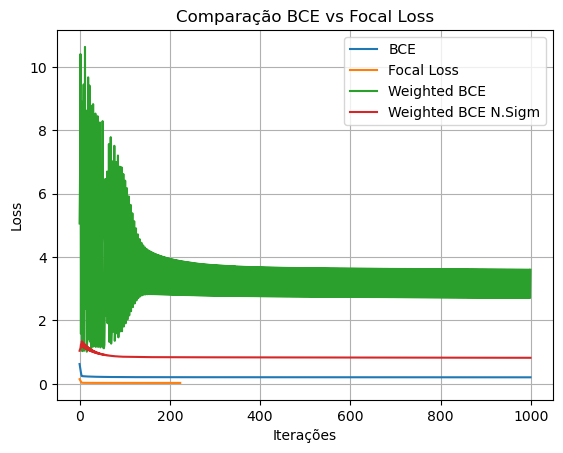

In [24]:
#Comparacao grafica dos erros dos modelos

plt.plot(model_bce.errors, label="BCE")
plt.plot(model_focal.errors, label="Focal Loss")
plt.plot(model_weighted.errors, label="Weighted BCE")
plt.plot(model_weighted_newSigmoid.errors, label="Weighted BCE N.Sigm")
plt.xlabel("Iterações")
plt.ylabel("Loss")
plt.title("Comparação BCE vs Focal Loss")
plt.legend()
plt.grid(True)
plt.show()



| Modelo        | Acuracia | Precisão | Recall | F1-score | Predição de classe 1? | Comentários                             |
|---------------|----------|----------|--------|----------|-----------------------|-----------------------------------------|
| BCE (padrão)  | 0.9364   | 0.00     | 0.00   | 0.00     | Nunca                 | Totalmente enviesado para classe 0      |
| Focal Loss    | 0.9377   | 0.00     | 0.00   | 0.00     | Nunca                 | Mesmo problema —                        |
| Weighted BCE  | 0.4185   | 0.08     | 0.84   | 0.15     | Sim                   | aprendeu algo sobre a classe 1          |
| Weighted BCE New Sig  | 0.8105   | 0.19     | 0.65   | 0.29     | Sim                   | aprendeu algo sobre a classe 1          |